In [1]:
# load all results
# deduplicate?
# remove fakes
# estimate magnitudes from light curves
# completeness correct
# make magnitude distribution

In [180]:
from salad.serialize import read
import matplotlib.pyplot as plt
from astropy.timeseries import LombScargle
import astropy.units as u
from pathlib import Path
import astropy.table
import numpy as np

def load_summary(search_prefix, detector, snr, time_type, search_label, step="filtered"):
    # get recoveries at a certain step
    p = Path(f"/epyc/projects/salad/search/{search_prefix}/DEEP/20190403/A0c/detector_{detector}/snr_{snr}/{time_type}/{search_label}")
    return read(list(p.rglob(f"{step}_summary.pkl"))[0])

def load_results(search_prefix, detector, snr, time_type, search_label, step="filtered"):
    # get recoveries at a certain step
    p = Path(f"/epyc/projects/salad/search/{search_prefix}/DEEP/20190403/A0c/detector_{detector}/snr_{snr}/{time_type}/{search_label}")
    return read(list(p.rglob(f"{step}.pkl"))[0])


def recoveries(search_prefix, detector, snr, time_type, search_label, step="filtered"):
    # get recoveries at a certain step
    p = Path(f"/epyc/projects/salad/search/{search_prefix}/DEEP/20190403/A0c/detector_{detector}/snr_{snr}/{time_type}/{search_label}")
    return read(list(p.rglob(f"{step}_recovery.pkl"))[0])

def was_found(fake_recovery, threshold=15, vmin=0.1, vmax=0.5):
    ret = []
    for o in fake_recovery:
        f = fake_recovery[o]
        found_points = False
        found_line = False
        n_points = 0
        n_lines = 0
        found_in = -1
        for c in f['points']:
            p = f['points'][c]
            precision = p['fake']/p['total']
            recall = p['fake']/f['catalog']['fake']
            if precision > 0.5:
                found_points = True
                n_points += 1
                found_in = c
                
            if c in f['line']:
                l = f['line'][c]
                line_recovery = l['fake']/l['total']
                if precision > 0.5 and line_recovery > 0.5:
                    found_line = True
                    n_lines += 1
        
        v = ((f['info']['vra']**2 + f['info']['vdec']**2)**0.5)
        if hasattr(v, "unit"):
            v = v.value
        ret.append(
            {
                "orbit": o,
                "found_points": found_points,
                "found_line": found_line,
                "points": f['catalog']['fake'],
                "n_points": n_points,
                "n_lines": n_lines,
                "fake_detection": f['catalog']['fake'],
                "fake_injection": f['catalog']['total'],
                "filtered": (v < vmin) | (v > vmax),
                "found_in": found_in
            }
        )
        
        if 'findable' in f['info']:
            ret[-1]['in_search'] = f['info']['findable']
        elif f['catalog']['total'] == 1:
            ret[-1]['in_search'] = False
            
            
    return astropy.table.Table(ret)


def wilson_score_interval(z_alpha, n_s, n_f):
    n = n_s + n_f
    m = (n_s + 0.5 * z_alpha**2) / (n + z_alpha**2)
    u = ((z_alpha) / (n + z_alpha**2)) *  ((n_s*n_f/n) + (z_alpha**2)/4)**0.5
    return m - u, m + u

def bin_detection(catalog, min_mag, max_mag, dm=0.5, min_visits=10, mag_col='mag', found_col='found'):
    fraction_recovered = []
    i = 0
    m = min_mag
    mag = []
    lower = min_mag
    errors = []
    while lower < max_mag:
        lower = min_mag + i * dm
        upper = min_mag + (i + 1) * dm
        a = catalog[(catalog[mag_col] >= lower) & (catalog[mag_col] < upper)]
        if len(a) > 0:
            num_recovered = a[found_col].sum()
            num_possible = len(a)#a['catalog_possible'].sum()
            
            fraction_recovered.append(num_recovered/num_possible)
            mag.append((upper + lower) / 2)
            # num_recovered / num_total
            # sqrt(dx^2 + dy^2)
            l, u = wilson_score_interval(1, num_recovered, num_possible - num_recovered)
            errors.append([num_recovered/num_possible - l, u - num_recovered/num_possible])
#             errors.append((num_recovered + num_possible)**-0.5) # sqrt(dr**2 + da**2) where dr=sqrt(r)

        i += 1

    return mag, fraction_recovered, np.array(errors).T
from scipy.optimize import minimize, curve_fit
import numpy as np
from autograd import elementwise_grad as egrad
from autograd import jacobian, hessian
import autograd.numpy as autograd_np

def p(m, c, k, m_50):
    return c / (1 + autograd_np.exp(k * (m - m_50)))

def log_p(m, c, k, m_50):
    return autograd_np.log(c) - autograd_np.log(1 + autograd_np.exp(k * (m - m_50)))

def p_3(m, c, k1, k2, m_25):
    return p(m, c, k1, m_25) * p(m, 1, k2, m_25)

def log_p_3(m, c, k1, k2, m_25):
    return log_p(m, c, k1, m_25) + log_p(m, 1, k2, m_25)

def log_l(c, k, m_50, recovered_mag, missed_mag):
    if c > 1 or c < 0:
        return -autograd_np.inf
    return autograd_np.sum(log_p(recovered_mag, c, k, m_50)) + autograd_np.sum(autograd_np.log(1 - p(missed_mag, c, k, m_50)))


def log_l_3(c, k1, k2, m_25, recovered_mag, missed_mag):
    if c > 1 or c < 0:
        return -autograd_np.inf
    return (
        autograd_np.sum(autograd_np.log(p_3(recovered_mag, c, k1, k2, m_25))) + 
        autograd_np.sum(autograd_np.log(1 - p_3(missed_mag, c, k1, k2, m_25)))
    )

def fit_completeness(recovered_mag, missed_mag, eq=1, **kwargs):
    minimize_kwargs = dict(
        method="Nelder-Mead", 
        options=dict(maxiter=int(1e3))        
    )
    minimize_kwargs.update(kwargs)
    if eq == 1:
        log_likelihood = log_l
        init_x = autograd_np.array(minimize_kwargs.pop("init_x", [0.8, 1, 24]))
    else:
        log_likelihood = log_l_3
        init_x = autograd_np.array(minimize_kwargs.pop("init_x", [0.8, 1, 1, 24]))
    
    f = lambda x : -log_likelihood(*x, recovered_mag, missed_mag)
    df = egrad(f)
    jac = jacobian(f)
    hess = hessian(f)
    
    if minimize_kwargs['method'] != "Nelder-Mead":
        minimize_kwargs['jac'] = jac
        minimize_kwargs['hess'] = hess
    opt_result = minimize(f, init_x, **minimize_kwargs)
        
    return opt_result, hess(opt_result.x)


def do_fit(results, mag_col='mag', found_col='found'):
    recovered_mag = results[results[found_col]][mag_col].value
    missed_mag = results[~results[found_col]][mag_col].value

    opt_result, hess = fit_completeness(recovered_mag, missed_mag, eq=1)

    d = None
    if opt_result.success:
        best_fit = opt_result.x
        if hess is not None:
            fit_std = autograd_np.sqrt(autograd_np.diag(autograd_np.linalg.inv(hess)))
        else:
            fit_std = autograd_np.array([autograd_np.nan, autograd_np.nan, autograd_np.nan])
        d = {
            "c": best_fit[0],
            "k": best_fit[1],
            "m_50": best_fit[2],
            "sigma_c": fit_std[0],
            "sigma_k": fit_std[1],
            "sigma_m_50": fit_std[2],
        }

    return d


In [9]:
search_prefix = "new"

f = []
for detector in range(1, 63):
    if detector in [2, 31, 61]:
        continue
    try:
        fakes = read(f"/epyc/projects/salad/search/{search_prefix}/DEEP/20190403/A0c/detector_{detector}/fakes.pkl")
    except:
        print(detector)
        continue
    f.append(fakes)
fakes = astropy.table.vstack(f)


mags = []
for g in fakes.group_by("ORBITID").groups:
    mags.append(
        {
            "orbit": g[0]['ORBITID'],
            "mag": np.median(g['MAG'])
        }
    )
mags = astropy.table.Table(mags)

In [69]:
import numpy as np

snrs = [3.0]
detectors = [i for i in range(1, 63) if i not in [2, 31, 61]]
summary_data = {}
fit_data = {}
fit_params = {}
# m_50 = []
# sigma_m_50 = []
# max_mags = []
for snr in snrs:
    fo = []
    for detector in detectors:
        try:
            r = recoveries("new", detector, snr, "regular", "asteroid")
        except:
            print(snr, detector)
        found = was_found(r)
        found['detector'] = detector
        fo.append(found)
            
            
    found = astropy.table.vstack(fo)
    fo = []
    for g in found.group_by("orbit"):
        g = astropy.table.Table(g)
        if len(g) > 1:
            idx = np.argmax(g[''])
            g['found_points'] = np.logical_or.reduce(g['found_points'])
            g['found_line'] = np.logical_or.reduce(g['found_line'])
            g['in_search'] = np.logical_or.reduce(g['in_search'])
            fo.append(astropy.table.Table(g[0]))
        else:
            fo.append(g)

    found = astropy.table.vstack(fo)
    

    # how do I distinguish t['points'] = 0 meaning not detected vs not included because of masks?

    t = astropy.table.join(found, mags, keys=['orbit'])
    fit_data[snr] = t

In [93]:
filters = [
    lambda x : np.ones(len(x)).astype(bool),
    lambda x : x['in_search'],
    lambda x : (x['in_search']) & (~x['filtered']),
    lambda x : (x['in_search']) & (~x['filtered']) & (x['fake_injection'] > 15),
]
t = fit_data[3.0]
_t = t[filters[-1](t)]
fit_result = do_fit(_t, found_col='found_points')
fit_result

{'c': 0.8954284885477388,
 'k': 4.586298591238114,
 'm_50': 24.734785477540825,
 'sigma_c': 0.028614404797222825,
 'sigma_k': 0.917633462342811,
 'sigma_m_50': 0.07342103431276124}

In [94]:
correction = lambda m : p(m, fit_result['c'], fit_result['k'], fit_result['m_50'])

In [70]:
found_objects = fit_data[3.0][fit_data[3.0]['found_in'] != -1]

In [71]:
found_objects

orbit,found_points,found_line,points,n_points,n_lines,fake_detection,fake_injection,filtered,found_in,in_search,detector,mag
int64,bool,bool,int64,int64,int64,int64,int64,bool,int64,bool,int64,float64
5854665,True,True,95,1,1,95,104,False,0,True,39,23.582836462986492
10002376,True,False,89,1,0,89,104,False,10,True,59,24.054322260817777
10041343,True,False,100,1,0,100,104,False,103,False,1,22.428969812125573
10049768,True,True,24,1,1,24,99,False,204,True,28,24.739678663254164
10065221,True,True,104,1,1,104,104,False,2,True,36,23.188854359615995
10113319,True,True,100,1,1,100,104,False,0,True,47,23.584115512450673
10129264,True,False,103,1,0,103,104,False,0,True,23,22.674934174342177
10183346,True,True,92,1,1,92,104,False,9,True,50,23.891353844131483
10198848,True,True,42,1,1,42,104,False,13,True,28,23.55203109034497


In [ ]:
for snr in [3.0]:
    for 

In [43]:
clusters = load_summary("new", 1, 3.0, "regular", "asteroid")

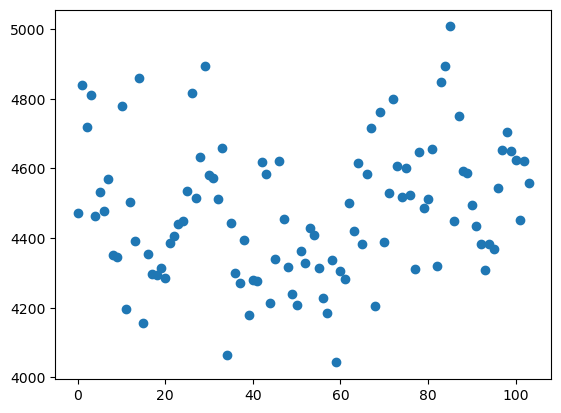

In [45]:
lc = clusters[0].summary['light_curve']
plt.scatter(np.arange(len(lc['flux'])), lc['flux'])

In [220]:
def mag_for(cluster):
    s = cluster.summary
    lc = s['light_curve']
    median_flux = np.median(lc['flux'])
    return -5/2 * np.log10(median_flux) + 31

def coadd_snr_for(cluster):
    s = cluster.summary
    lc = s['light_curve']
    m = lc['mask'] != 0
    f = np.sum(lc['flux'][m] / lc['sigma'][m]**2) / np.sum((1/lc['sigma'][m]**2))
    var_f = 1/np.sum((1/lc['sigma']**2))
    snr = f / (var_f**0.5)
    return snr

In [233]:
cluster_data = []
for snr in [3.0]:
    for detector in range(1, 63):
        if detector in [2, 31, 61]:
            continue
        try:
            clusters = load_summary("new", detector, snr, "regular", "asteroid")
        except:
            print(snr, detector)
            continue
        for c in clusters:
            cluster_data.append(
                {
                    "cluster": c,
                    "detector": detector,
                    "mag": mag_for(clusters[c]),
                    "coadd_snr": coadd_snr_for(clusters[c]),
                }
            )

            
cluster_data = astropy.table.Table(cluster_data)

/tmp/ipykernel_31601/546390288.py:11: RuntimeWarning: invalid value encountered in scalar divide
  f = np.sum(lc['flux'][m] / lc['sigma'][m]**2) / np.sum((1/lc['sigma'][m]**2))


In [243]:
cluster_data[np.nanargmin(cluster_data['coadd_snr'])]

cluster,detector,mag,coadd_snr
int64,int64,float64,float64
10,11,23.375737050064323,-90.96151768986553


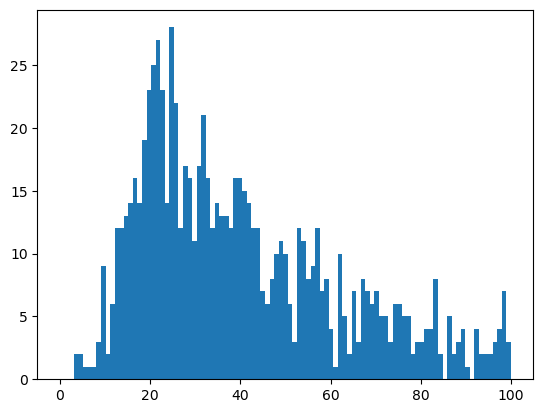

In [245]:
plt.hist(cluster_data['coadd_snr'], bins=np.linspace(0, 100, 100))
plt.show()

/tmp/ipykernel_31601/2841796244.py:1: RuntimeWarning: invalid value encountered in log10
  plt.hist(np.log10(cluster_data['coadd_snr']), bins='auto')


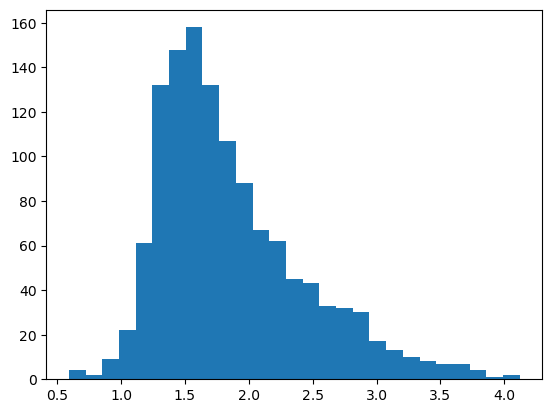

In [236]:
plt.hist(np.log10(cluster_data['coadd_snr']), bins='auto')
plt.show()

In [247]:
clusters[0].summary

{'expnum': array([845872, 845873, 845874, 845875, 845876, 845877, 845878, 845879,
        845880, 845881, 845882, 845883, 845884, 845885, 845886, 845887,
        845888, 845889, 845890, 845891, 845892, 845893, 845894, 845895,
        845896, 845897, 845898, 845899, 845900, 845901, 845902, 845903,
        845904, 845905, 845906, 845907, 845908, 845909, 845910, 845911,
        845912, 845913, 845914, 845915, 845916, 845917, 845918, 845919,
        845920, 845921, 845922, 845923, 845924, 845925, 845926, 845927,
        845928, 845929, 845930, 845931, 845932, 845933, 845934, 845935,
        845936, 845937, 845938, 845939, 845940, 845941, 845942, 845943,
        845944, 845945, 845946, 845947, 845948, 845949, 845950, 845951,
        845952, 845953, 845954, 845955, 845956, 845957, 845958, 845959,
        845960, 845961, 845962, 845963, 845964, 845965, 845966, 845967,
        845968, 845969, 845970, 845971, 845972, 845973, 845974, 845975]),
 'time': array([58577.21560552, 58577.21731683, 5857

In [221]:
coadd_snr_for(clusters[0])

329.9902905957248

In [210]:
cluster_data[cluster_data['coadd_snr'].argmin()]

cluster,detector,mag,coadd_snr
int64,int64,float64,float64
30,57,23.7365802250917,-23.22927833178213


In [65]:
found_objects

orbit,found_points,found_line,points,n_points,n_lines,fake_detection,fake_injection,filtered,found_in,in_search,detector,mag
int64,bool,bool,int64,int64,int64,int64,int64,bool,object,bool,int64,float64
5854665,True,True,95,1,1,95,104,False,0,True,39,23.582836462986492
10002376,True,False,89,1,0,89,104,False,10,True,59,24.054322260817777
10041343,True,False,100,1,0,100,104,False,103,False,1,22.428969812125573
10049768,True,True,24,1,1,24,99,False,204,True,28,24.739678663254164
10065221,True,True,104,1,1,104,104,False,2,True,36,23.188854359615995
10113319,True,True,100,1,1,100,104,False,0,True,47,23.584115512450673
10129264,True,False,103,1,0,103,104,False,0,True,23,22.674934174342177
10183346,True,True,92,1,1,92,104,False,9,True,50,23.891353844131483
10198848,True,True,42,1,1,42,104,False,13,True,28,23.55203109034497


In [80]:
# How do you do an exclusive join?

# astropy.table.join(
#     cluster_data, 
#     found_objects, 
#     keys_left=['cluster', 'detector'], 
#     keys_right=['found_in', 'detector'],
# )

not_in = []
for c, d in found_objects[['found_in', 'detector']]:
    not_in.append(np.where((cluster_data['cluster'] == c) & (cluster_data['detector'] == d))[0][0])
    
include = []
for i in range(len(cluster_data)):
    if i not in not_in:
        include.append(i)

In [86]:
cluster_data_no_fakes = cluster_data[include]

In [256]:
cluster_data_no_fakes[cluster_data_no_fakes['mag'].argsort()[-10:]]

cluster,detector,mag
int64,int64,float64
374,48,25.481433787675773
155,37,25.543932917019063
12,52,25.5488376095558
402,28,25.58801744188076
143,40,25.593907720384586
93,34,25.664564542660067
220,20,25.669830405311934
30,22,26.403790400142157
224,52,27.18085745931586


In [97]:
17.83403646 - 16.76706691

1.0669695499999996

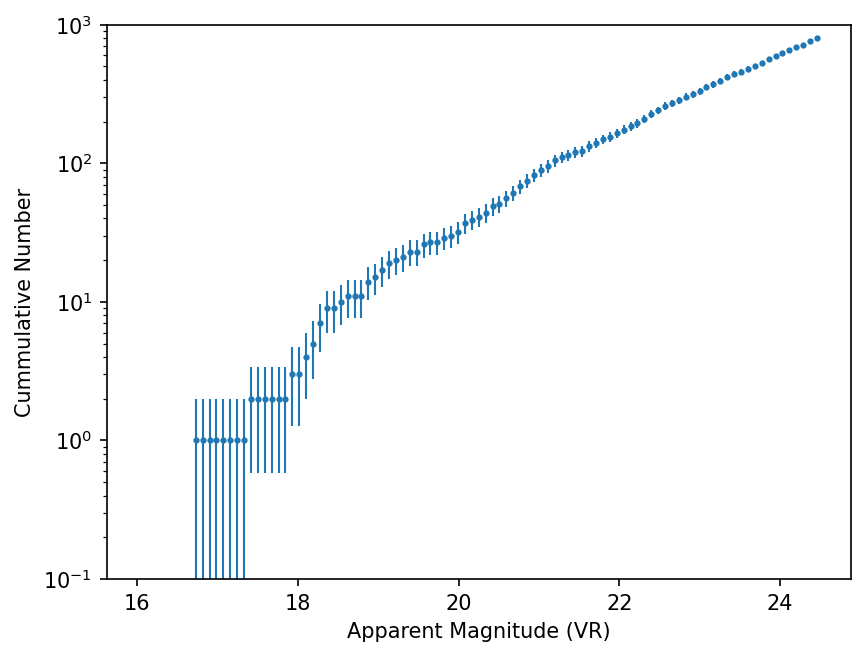

In [260]:
counts, left = np.histogram(cluster_data_no_fakes['mag'], np.linspace(16, 24.5, 100))
centers = (left + (left[1] - left[0])/2)[:-1]
corrected_counts = counts/correction(centers)

x = centers
y = np.cumsum(counts)
yerr = np.sqrt(y)

fig = plt.figure(dpi=150)
plt.errorbar(x, y, yerr=yerr, fmt='o', ms=2, lw=1)
plt.xlabel("Apparent Magnitude (VR)")
plt.ylabel("Cummulative Number")
plt.yscale("log")
plt.ylim(1e-1, 1e3)
plt.show()

/tmp/ipykernel_31601/3831440452.py:5: RuntimeWarning: divide by zero encountered in log10
  plt.errorbar(x, np.log10(y), yerr=yerr/(y*np.log(10)), fmt='o', ms=2, lw=1)
/tmp/ipykernel_31601/3831440452.py:5: RuntimeWarning: invalid value encountered in divide
  plt.errorbar(x, np.log10(y), yerr=yerr/(y*np.log(10)), fmt='o', ms=2, lw=1)


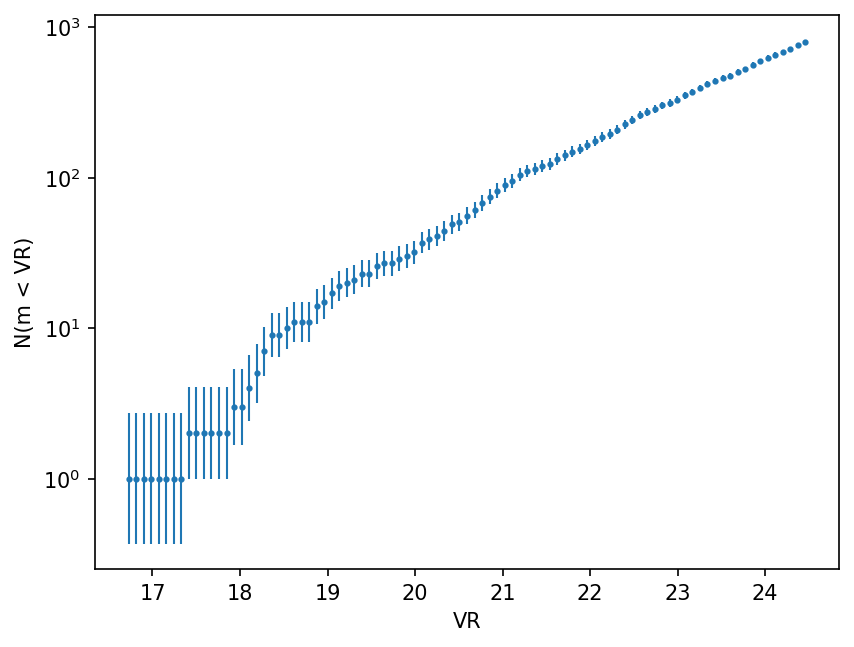

In [199]:
m = (x > 21)
f = np.polyfit(x[m], np.log10(y[m]), deg=1)

fig = plt.figure(dpi=150)
plt.errorbar(x, np.log10(y), yerr=yerr/(y*np.log(10)), fmt='o', ms=2, lw=1)
y_hat = f[0] * x[m] + f[1]
# plt.plot(x[m], y_hat, zorder=10)

plt.xlabel("VR")
plt.ylabel("N(m < VR)")
plt.yticks([0, 1, 2, 3], ["$10^{0}$", "$10^{1}$", "$10^{2}$", "$10^{3}$"])
# _y, _yl = plt.yticks()
# plt.yticks(_y, ["$" + f"10^{_:0.1f}" + "$" for _ in _y])
# plt.yscale("log")
# plt.ylim(1e-1, 2e3)
plt.show()

In [198]:
f

array([ 0.27779589, -3.87599591])

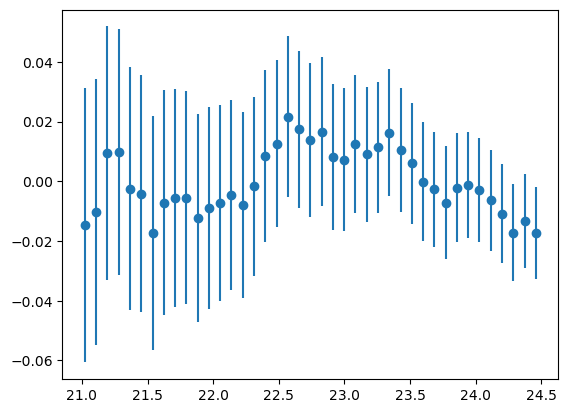

In [184]:
plt.errorbar(
    x[m], 
    np.log10(y[m]) - y_hat, yerr=yerr[m]/(y[m]*np.log(10)),
    fmt='o'
)
plt.show()

In [119]:
# wilson_score_interval(1, )

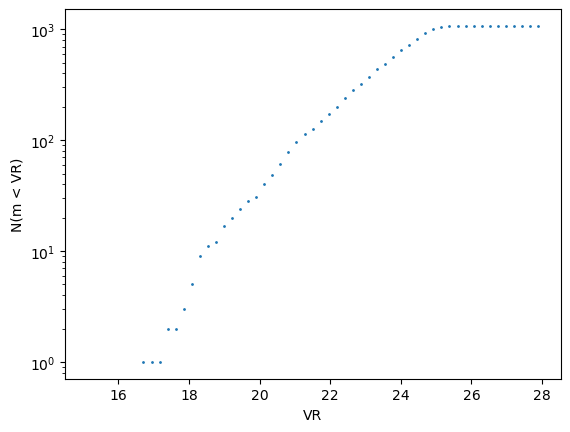

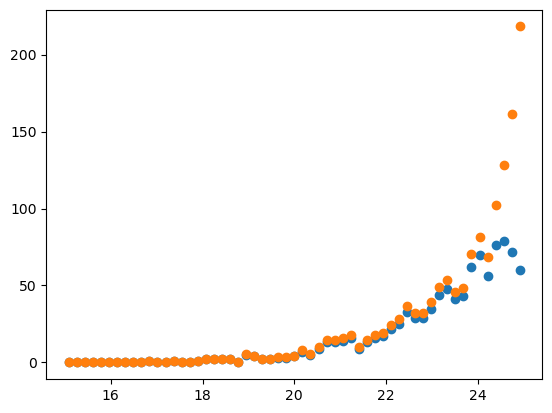

In [122]:
plt.scatter(centers, counts)
plt.scatter(centers, corrected_counts)
plt.show()

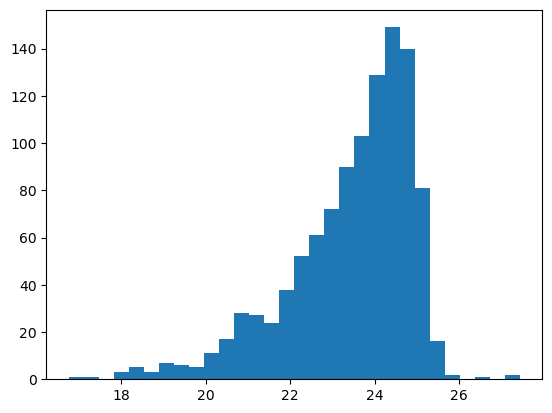

In [88]:
plt.hist(cluster_data_no_fakes['mag'], bins='auto')
plt.show()

In [250]:
clusters[0].line.beta

<Quantity [[-0.14730002,  0.07354948]] deg / d>